<a href="https://colab.research.google.com/github/odus05/Pyspark/blob/master/Image_DL(Tranfer-Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Spark-DL

In [0]:
# [출처:https://github.com/FavioVazquez/deep-learning-pyspark/blob/master/SparkDL.ipynb]

# !pip install pyspark
# !pip install sparkdl
# !pip install tensorframes
# !pip install tensorflow==1.6.0
# !pip install keras==2.1.5


# !sudo apt install openjdk-8-jdk
# !sudo update-alternatives --config java   #java-8
# !java -version


In [0]:
import os
SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.0.0-spark2.3-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("DL with Spark Deep Cognition").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=DL with Spark Deep Cognition>

**Loading Images**

In [0]:
# !curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
# !tar xzf flower_photos.tgz
# !mkdir flower_photos/sample

# !cp flower_photos/daisy/100080576_f52e8ee070_n.jpg flower_photos/sample/
# !cp flower_photos/daisy/10140303196_b88d3d6cec.jpg flower_photos/sample/
# !cp flower_photos/tulips/100930342_92e8746431_n.jpg flower_photos/sample/

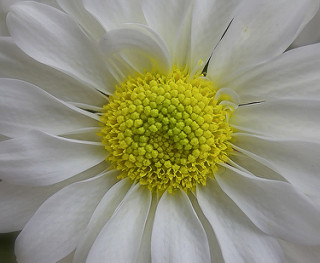

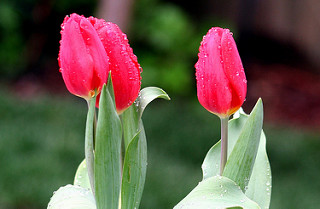

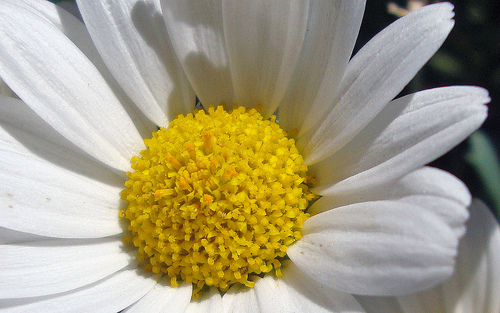

In [4]:
files = !ls flower_photos/sample/*.jpg

import IPython.display as dp
images = []
# Create list of image objects
for file_name in files:
  images.append(dp.Image(filename=file_name, format='png'))

# Display all images
for img in images:
  dp.display_png(img)

In [5]:
from pyspark.ml.image import ImageSchema
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")
image_df.show()

+--------------------+
|               image|
+--------------------+
|[file:/content/fl...|
|[file:/content/fl...|
|[file:/content/fl...|
+--------------------+



In [0]:
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from sparkdl.image import imageIO

tulips_df = ImageSchema.readImages("flower_photos/tulips").withColumn("label", lit(1))
daisy_df = imageIO.readImagesWithCustomFn("flower_photos/daisy", decode_f=imageIO.PIL_decode).withColumn("label", lit(0))

tulips_train, tulips_test, _ = tulips_df.randomSplit([0.1, 0.05, 0.85])  # use larger training sets (e.g. [0.6, 0.4] for getting more images)
daisy_train, daisy_test, _ = daisy_df.randomSplit([0.1, 0.05, 0.85])     # use larger training sets (e.g. [0.6, 0.4] for getting more images)

train_df = tulips_train.unionAll(daisy_train)
test_df = tulips_test.unionAll(daisy_test)

# Under the hood, each of the partitions is fully loaded in memory, which may be expensive.
# This ensure that each of the paritions has a small size.
train_df = train_df.repartition(100)
test_df = test_df.repartition(100)

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])

p_model = p.fit(train_df)

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tested_df = p_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
score = evaluator.evaluate(tested_df.select("prediction", "label"))
print("Test set accuracy = " + str(score))

Test set accuracy = 0.9705882352941176


In [9]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, expr

def _p1(v):
  return float(v.array[1])

take_one = udf(_p1, DoubleType())

df = tested_df.withColumn("p", take_one(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p - label)"), ascending=False)
wrong_df.select("image.origin", "p", "label").show(10)

+--------------------+-------------------+-----+
|              origin|                  p|label|
+--------------------+-------------------+-----+
|file:/content/flo...| 0.8201517391821894|    0|
|file:/content/flo...| 0.4362416478527888|    1|
|file:/content/flo...| 0.4901530375498193|    0|
|file:/content/flo...|   0.45274903164679|    0|
|file:/content/flo...|0.41251176812810475|    0|
|file:/content/flo...| 0.5964551770424712|    1|
|file:/content/flo...| 0.5989214477951715|    1|
|file:/content/flo...| 0.6677591801563922|    1|
|file:/content/flo...| 0.7667946068568425|    1|
|file:/content/flo...| 0.7997245351774762|    1|
+--------------------+-------------------+-----+
only showing top 10 rows



In [10]:
from sparkdl import DeepImagePredictor
# Read images using Spark
image_df = ImageSchema.readImages("flower_photos/sample/")

predictor = DeepImagePredictor(inputCol="image", outputCol="predicted_labels", modelName="InceptionV3", decodePredictions=True, topK=10)
predictions_df = predictor.transform(image_df)

predictions_df.select("predicted_labels").show(n=3, truncate=False)

INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|predicted_labels                                                                                                                                                                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------

In [12]:
df = p_model.transform(image_df)
# 100930342_92e8746431_n.jpg not a daisy
df.select("image.origin",(1-take_one(df.probability)).alias("p_daisy")).show(truncate=False)

+-------------------------------------------------------------+-------------------+
|origin                                                       |p_daisy            |
+-------------------------------------------------------------+-------------------+
|file:/content/flower_photos/sample/100080576_f52e8ee070_n.jpg|0.9626436393889608 |
|file:/content/flower_photos/sample/100930342_92e8746431_n.jpg|0.15802816962648358|
|file:/content/flower_photos/sample/10140303196_b88d3d6cec.jpg|0.9816946059865278 |
+-------------------------------------------------------------+-------------------+



KERAS

In [0]:
import numpy as np
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from pyspark.sql.types import StringType, StructType
from sparkdl import KerasImageFileTransformer


# Save InceptionV3 Model as file. 
model = InceptionV3(weights='imagenet')
model.save('InceptionV3-model.h5') # saves to the local filesystem

def Preprocess(path):
  # this is a typical way to load and prep images in keras
  image = img_to_array(load_img(path, target_size=(299,299))) # image dimensions for InceptionV3
  image = np.expand_dims(image, axis=0)
  return preprocess_input(image)

transformer = KerasImageFileTransformer(inputCol='uri',
                                        outputCol='predictions',
                                        modelFile='InceptionV3-model.h5',
                                        imageLoader=Preprocess,
                                        outputMode='vector')

In [24]:
files = !ls flower_photos/sample/*.jpg
path_df = spark.createDataFrame(files, StringType()).toDF("uri")
print(path_df.show())

keras_pred_df = transformer.transform(path_df)
keras_pred_df.select("uri", "predictions").show(n=5)

+--------------------+
|                 uri|
+--------------------+
|flower_photos/sam...|
|flower_photos/sam...|
|flower_photos/sam...|
+--------------------+

None


/usr/local/lib/python3.6/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
+--------------------+--------------------+
|                 uri|         predictions|
+--------------------+--------------------+
|flower_photos/sam...|[7.43818964110687...|
|flower_photos/sam...|[3.56566015398129...|
|flower_photos/sam...|[3.49412839568685...|
+--------------------+--------------------+



In [31]:
# 입력값으로 최대 2차원까지 가능!!
from sparkdl import KerasTransformer
from pyspark.sql.types import StringType, StructType, StructField, ArrayType, FloatType
from keras.models import Sequential
from keras.layers import Dense

# Generate random input data
num_features = 10
num_examples = 100
input_data = [{"features":np.random.randn(num_features).astype(float).tolist()} for i in range(num_examples)]
schema = StructType([StructField("features", ArrayType(FloatType()), True)])
input_df = spark.createDataFrame(input_data, schema)

# Create and save a single-hidden-layer Keras model for binary classification
# NOTE: In a typical workflow, we'd train the model before exporting it to disk,
# but we skip that step here for brevity
model = Sequential()
model.add(Dense(20, input_shape=[num_features], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model_path = "simple-binary-classification"
model.save(model_path)
# Create transformer and apply it to our input data
transformer = KerasTransformer(inputCol='features', outputCol='predictions', modelFile=model_path)
final_df = transformer.transform(input_df)
final_df.show()


+------------+--------------------+
| predictions|            features|
+------------+--------------------+
| [0.7240294]|[0.107631214, 0.4...|
| [0.6669082]|[-0.6639359, -0.0...|
|[0.43907166]|[1.1674545, -0.52...|
| [0.5066863]|[0.27454448, -1.1...|
| [0.6339574]|[-0.10440762, -0....|
| [0.7585804]|[-0.70774263, 0.6...|
| [0.5194628]|[0.015202031, -0....|
| [0.4987659]|[0.3442329, -0.51...|
|[0.53502715]|[-0.44557458, -0....|
| [0.6266264]|[-0.32860082, 2.3...|
|  [0.508041]|[-1.5865542, 0.32...|
|[0.38962454]|[0.833887, 0.7325...|
| [0.6159822]|[-0.6402937, 0.23...|
|[0.35226968]|[1.0799308, 0.372...|
| [0.5604552]|[-0.9884735, -0.8...|
| [0.3706815]|[0.61002314, -0.1...|
|  [0.358759]|[-0.32557714, 0.3...|
| [0.5125828]|[-1.611965, 0.179...|
|[0.46888036]|[0.87165457, -0.9...|
|[0.50111717]|[-0.4882775, 0.06...|
+------------+--------------------+
only showing top 20 rows



Deploying Models in SQL

In [32]:
# Model to UDF registration
from sparkdl.udf.keras_image_model import registerKerasImageUDF
registerKerasImageUDF('InceptionV3_UDF', InceptionV3(weights='imagenet'))

# Preprocessing func to UDF registration.
def Preprocess(path):
  # this is a typical way to load and prep images in keras
  image = img_to_array(load_img(path, target_size=(299,299))).astype(np.uint8) # image dimensions for InceptionV3
  image = np.expand_dims(image, axis=0)
  return preprocess_input(image) 

registerKerasImageUDF("InceptionV3_UDF_with_Preprocessing", InceptionV3(weights='imagenet'), Preprocess)

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


/usr/local/lib/python3.6/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 378 variables.
Converted 378 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [44]:
from pyspark.ml.image import ImageSchema
image_df = ImageSchema.readImages("flower_photos/sample/")
image_df.registerTempTable("sample_images")
print(image_df.show(n=5))
spark.sql("SELECT InceptionV3_UDF_with_Preprocessing(image) as predictions FROM sample_images").show(truncate=False)

+--------------------+
|               image|
+--------------------+
|[file:/content/fl...|
|[file:/content/fl...|
|[file:/content/fl...|
+--------------------+

None


AttributeError: ignored